# Hand gesture classification using CNN (Part-1).

<img src="https://i.ibb.co/7nwYnCB/Screen-Shot-2020-08-14-at-4-35-56-AM.png" alt="Screen-Shot-2020-08-14-at-4-35-56-AM" border="0" />

### A few days back, I saw this cool app on the internet that would look at your hand using the webcam and based on the palm gesture, it tries to come up with a similar emoji.
### The idea was simple yet amusing to watch. Next thing I thought was why not code something similar since it would be a decent hands-on project for anyone beginning with deeplearning.

## Project overview: I've divided the project into 2 parts:
### 1. Part 1: In this part we'll look at how to design and train a CNN that can predict the input image of the hand gesture and predict the class label.
### 2. Part 2: In this part we'll take the input from user and predict the hand gesture in realtime. The steps are:
- Capturing image stream (video) from the user's webcam.
- Detecting the hand
- Segmenting out the hand gesture image
- Predicting the class label of the hand gesture
- Replacing the hand gesture from the original input with the emoji picture that corresponds to the predicted class.


## About the data:
### Since this is a 5 class classification problem, we need data for each of the 5 classes to train our model. To make things even simpler and fast, we'll be using binary images for training. Let's take a look at some of the images from each of the 5 classes that we'll be using.
<img src="https://i.ibb.co/6vmhbCD/download-2.png" alt="download-2" border="0">

### In the dataset we have around 3000 images for each of the 5 class labels.
### Let's take a look at the emoji images that correspond to the 5 class lables:
<img src="https://i.ibb.co/B46MbgQ/Screen-Shot-2020-08-15-at-3-38-40-AM.png" alt="Screen-Shot-2020-08-15-at-3-38-40-AM" border="0">

## Let's begin with the part 1 of this project. We'll go through 5 steps in this part:
* Collecting the data.
* Preparing the data.
* Designing the CNN architecture and defining the evaluation metrics.
* Training the CNN Model.
* Analysing the model performance.
* Saving the model weights so that we can directly use the pretrained model in part 2.

### Let's begin by importing the necessary libraries.

In [ ]:
# Importing necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
import seaborn as sns
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
sns.set()

## Collecting the data
#### If we take a look at the file system of the images, inside the data folder, there are 5 folders from class_1 to class_5 and inside each folder we have 1460 images from class_i_1 to class_i_1460. The images are named in a format accepted by the keras ImageDataGenerator library. Eg. For an image with name class_x_y.jpg 'x' corresponds the class that image belongs to and 'y' corresponds to the image number in that class. So, in our case, x will range from 1 to 5 and y will range from 1 to 1460.
<img src="https://i.ibb.co/X5vwbjZ/Screen-Shot-2020-08-15-at-12-56-54-AM.png" alt="Screen-Shot-2020-08-15-at-12-56-54-AM" border="0">

#### I'm using ImageDataGenerator because it provides multiple image augmentation functions like rotation, zoom, width and height shift etc. And since we have only 1460 images to begin with, we should perform some image augmentation.
#### You can read more about ImageDataGenerator using the links below:
[Keras preprocessing documentation](https://keras.io/api/preprocessing/image/)

[Creating a dataset for ImageDataGenerator](https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720)

Find the code for generating the data on my github repo using [this](https://github.com/SarthakV7/AI-Hand-gesture-emoji-detection/blob/master/data_creator.py) link

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('../input/hand-gesture-to-emoji-data/emoji_data/data/Train',
                                                    target_size=(150, 150),
                                                    batch_size=2,
                                                    color_mode='grayscale',
                                                    class_mode="sparse",
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory('../input/hand-gesture-to-emoji-data/emoji_data/data/Valid',
                                                        target_size=(150, 150),
                                                        batch_size=2,
                                                        color_mode='grayscale',
                                                        class_mode="sparse")

Found 6500 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


## Preparing the data
### Now we'll convert the data into a numpy array, split into train and test/CV sets and reshape it to make it model compatible.

## Designing the CNN architecture and defining the evaluation metrics.

In [21]:
# Metrics for checking the model performance while training
import tensorflow as tf
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro')

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [22]:
# Callback for stopping the learning if the model reaches a f1-score > 0.999 on the CV/test data.
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.98 and logs.get('custom_f1score') > 0.98):
      self.model.stop_training = True

In [23]:
# Model architecture.
K.clear_session()
ip = Input(shape = (150,150,1))
z = Conv2D(filters = 32, kernel_size = (64,64), padding='same', input_shape = (150,150,1), activation='relu')(ip)
z = Conv2D(filters = 64, kernel_size = (16,16), padding='same', input_shape = (150,150,1), activation='relu')(z)
z = Conv2D(filters = 128, kernel_size = (8,8), padding='same', input_shape = (150,150,1), activation='relu')(z)
z = MaxPool2D(pool_size = (4,4))(z)
z = Flatten()(z)
z = Dense(32, activation='relu')(z)
op = Dense(5, activation='softmax')(z)
model = Model(inputs=ip, outputs=op)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.00001), metrics=[custom_f1score])

In [24]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      131104    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      524352    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 128)     524416    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 32)               

## Training the CNN Model.

In [25]:
callbacks = [stop_training_callback()]
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1, callbacks=callbacks)
model.fit(train_generator,
          epochs=10,
          validation_data=validation_generator,
          callbacks=callbacks,
          verbose=1)

Epoch 1/10
3250/3250 [==============================] - 163s 50ms/step - loss: 0.7827 - custom_f1score: 0.6786 - val_loss: 0.0212 - val_custom_f1score: 1.0000
Epoch 2/10
3250/3250 [==============================] - 163s 50ms/step - loss: 0.1708 - custom_f1score: 0.9418 - val_loss: 0.0715 - val_custom_f1score: 0.9650
Epoch 3/10
3250/3250 [==============================] - 163s 50ms/step - loss: 0.1073 - custom_f1score: 0.9678 - val_loss: 0.0044 - val_custom_f1score: 1.0000
Epoch 4/10
3250/3250 [==============================] - 162s 50ms/step - loss: 0.0754 - custom_f1score: 0.9757 - val_loss: 0.0038 - val_custom_f1score: 1.0000
Epoch 5/10
3250/3250 [==============================] - 163s 50ms/step - loss: 0.0622 - custom_f1score: 0.9802 - val_loss: 0.0762 - val_custom_f1score: 0.9650
Epoch 6/10
3250/3250 [==============================] - 163s 50ms/step - loss: 0.0509 - custom_f1score: 0.9818 - val_loss: 0.0014 - val_custom_f1score: 1.0000


## Analysing the model performance.

In [44]:
test_generator = test_datagen.flow_from_directory('../input/hand-gesture-to-emoji-data/emoji_data/data/Valid',
                                                    target_size=(150, 150),
                                                    batch_size=1,
                                                    color_mode='grayscale',
                                                    class_mode="sparse")

Found 800 images belonging to 5 classes.


In [52]:
num = 0
y_pred = []
y_true = []
for img, y_actual in test_generator:
    if num==600:
        break
    pred_label = model.predict(img).argmax()
    y_pred.append(pred_label)
    y_true.append(y_actual[0])
    num+=1

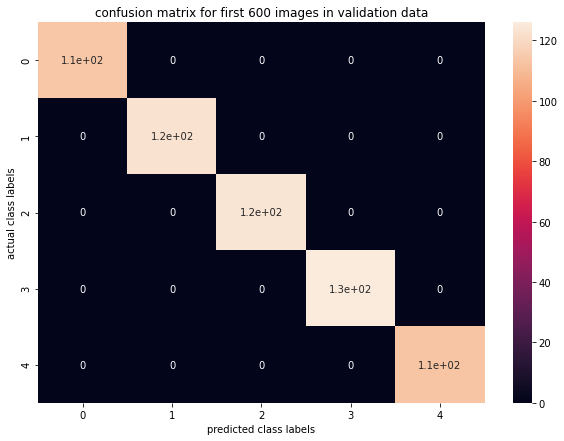

In [60]:
# Confusion matrix to check the misclassified points in test/CV data.
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index=np.arange(5), columns=np.arange(5))
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel('predicted class labels')
plt.ylabel('actual class labels')
plt.title('confusion matrix for first 600 images in validation data')
plt.show()

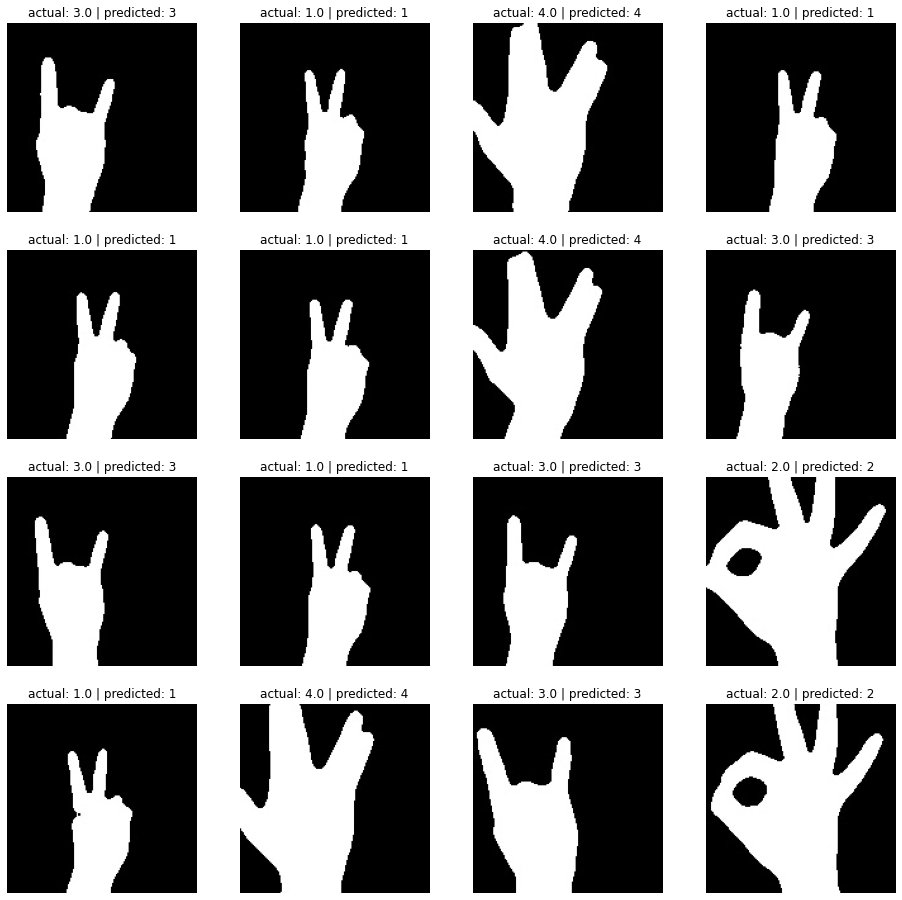

In [54]:
# sample images from test/CV data and their actual and predicted class labels.
size = y_test.shape[0]
plt.figure(figsize=(16,16))
for i,j in enumerate(test_generator):
    if i==16:
        break
    pred_label = model.predict(j[0]).argmax()
    actual_label = j[1][0]
    plt.subplot(4,4,i+1)
    img = j[0][0][:,:,0]
    plt.imshow(img, cmap='gray')
    plt.title(f'actual: {actual_label} | predicted: {pred_label}')
    plt.axis('off')
plt.show()

## Saving the model weights so that we can directly use the pretrained model in part 2.

In [55]:
model.save_weights('model_weights.h5')